# Quantum Energy Teleportation


<p align="center">
    <img src="qet_steps.png?raw=true" alt="QET steps" align="middle">
    <br/>
    <b>QET 3-step process</b>
</p>


This project is based on the quantum energy teleportation (QET) protocol by Hotta. QET allows us to exchange energy between two parties Alice and Bob (labelled $A$ and $B$). Like quantum teleportation by Bennett et. al. for quantum information, QET can be accomplished using pre-shared entanglement and local operations and classical communication. This [Quanta article](https://www.quantamagazine.org/physicists-use-quantum-mechanics-to-pull-energy-out-of-nothing-20230222/) is a good starting point to learn about it. 

In principle according to QET, $A$ injects energy into the vacuum and sends a classical bit to $B$, allowing $B$ to extract energy from the vacuum. This is explored in-depth using the formalism of quantum field theory in [[1]](#ref1). As we will see, the extracted energy can be negative, which goes against certain theories like [Penrose-Hawking energy conditions](https://en.wikipedia.org/wiki/Energy_condition). In practice, we only need two qubits and a small depth quantum circuit to perform QET, which makes an experimental setup quite possible on NISQ hardware. This demonstration was recently done on superconducting qubits [[2]](#ref2) on IBM Quantum, as well as earlier demonstrations done in NMR systems. Theoretically shown by Hotta, positive energy can be extracted by $B$ but this has not yet been shown experimentally.

The goal of this work is not to run QET on a quantum computer as was done in [[2]](#ref2), instead we use a simulator. We will be following Section 3 in [[1]](#ref1) as a guide to implement the minimal model of QET in PennyLane. We do some quick sanity checks on QET from a quantum information perspective. Following that we take a closer look at negative energy. We aim to optimize the parameters of the Hamiltonian that gives us the lowest energy using a hybrid quantum classical loop. Finally we try out noise models on both parties $A$ and $B$ to determine how noise would perturb the energy extracted by $B$.


Let's get started!

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

Create a device using 2 qubits and the mixed state simulator.

In [2]:
n_qubits = 2

dev = qml.device('default.mixed', wires=range(n_qubits))

We arbitrarily choose some initial values $h, k$ for the QET Hamiltonian. Later on, we will try to find optimal values for $h, k$ that minimize the energy.

In [3]:
# Hamiltonian parameters
h = 1
k = 2

Our ground state $|g\rangle$ is given by:

$$ 
|g\rangle = \frac{1}{\sqrt2} \sqrt{1 - \frac{h}{\sqrt{h^2 + k^2}}} |00\rangle - \frac{1}{\sqrt2} \sqrt{1 + \frac{h}{\sqrt{h^2 + k^2}}} |11\rangle
$$

In [4]:
# State vector for ground state
def ground_state_vector(h, k):
    # Hack to extract parameters in the variational case
    if isinstance(h, np.numpy_boxes.ArrayBox):
        h = h._value
        k = k._value
    
    g = np.zeros(2**n_qubits)
    g[0] = (1 / np.sqrt(2)) * np.sqrt(1 - h/np.sqrt(h**2 + k**2))
    g[-1] = (-1 / np.sqrt(2)) * np.sqrt(1 + h/np.sqrt(h**2 + k**2))
    
    return g

Our total Hamiltonian is a sum of three parts: a part that affects the parties $A$ and $B$ seperately and a potential term that affects both parties.
$$H_{\text{tot}} = H_A + H_B + V$$

Each contribution is given by:
$$
\begin{align}
H_{A}  &  =h\sigma_{A}^{z}+\frac{h^{2}}{\sqrt{h^{2}+k^{2}}},\notag\\
H_{B}  &  =h\sigma_{B}^{z}+\frac{h^{2}}{\sqrt{h^{2}+k^{2}}},\notag\\
V  &  =2k\sigma_{A}^{x}\sigma_{B}^{x}+\frac{2k^{2}}{\sqrt{h^{2}+k^{2}}}\notag
\end{align}
$$

In [5]:
coeffs = []
obs = []

coeffs.append(h)
obs.append(qml.PauliZ(0) @ qml.Identity(1))
coeffs.append(h**2 / np.sqrt(h**2 + k**2))
obs.append(qml.Identity(0) @ qml.Identity(1))
H_A = qml.Hamiltonian(coeffs, obs)

coeffs.clear()
obs.clear()
coeffs.append(h)
obs.append(qml.Identity(0) @ qml.PauliZ(1))
coeffs.append(h**2 / np.sqrt(h**2 + k**2))
obs.append(qml.Identity(0) @ qml.Identity(1))
H_B = qml.Hamiltonian(coeffs, obs)

coeffs.clear()
obs.clear()
coeffs.append(2 * k)
obs.append(qml.PauliX(0) @ qml.PauliX(1))
coeffs.append((2 * k**2) / np.sqrt(h**2 + k**2))
obs.append(qml.Identity(0) @ qml.Identity(1))
V = qml.Hamiltonian(coeffs, obs)

We check if the 3 components are Hermitian.

In [6]:
print(qml.is_hermitian(H_A))
print(qml.is_hermitian(H_B))
print(qml.is_hermitian(V))

True
True
True


Since the sum of Hermitian operators is Hermitian, $H_{\text{tot}}$ should also be Hermitian.

In [7]:
H_tot = H_A + H_B + V
qml.is_hermitian(H_tot)

True

Here is our circuit to prepare the ground state of $H_{\text{tot}}$.

In [8]:
@qml.qnode(dev)
def ground_state_energy(H):
    qml.MottonenStatePreparation(ground_state_vector(h, k), wires=range(n_qubits))
    return qml.expval(H)

The constant terms in the components $H_A, H_B, V$ are added in order to make the expectation value of each operator zero for the
ground state $|g\rangle$.

In [9]:
print(np.isclose(ground_state_energy(H_A), 0))
print(np.isclose(ground_state_energy(H_B), 0))
print(np.isclose(ground_state_energy(V), 0))

True
True
True


Here are the eigenvalues of $H_{\text{tot}}$.

In [10]:
qml.eigvals(H_tot)

/Users/nvenkat/anaconda3/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


array([ 1.78885438,  6.73312629, 14.73312629, 19.6773982 ])

Let's verify that $H_{\text{tot}}$ is PSD.

In [11]:
print(ground_state_energy(H_tot) >= 0)

True


In quantum mechanics, the rate of change of the expectation value of an operator $\hat{F}$ is given by:
$$
\frac{\text{d} \hat{F}}{\text{d}t} = \frac{1}{i\hbar} \langle\left[\hat{F}, \hat{H}\right]\rangle
$$

So if an operator commutes with the Hamiltonian, i.e $\left[\hat{F}, \hat{H}\right] = 0$, it is a conserved quantity.

Here we check if our measurement in the Pauli $X$ basis is energy conserving.

In [12]:
sigmaX_on_A = qml.PauliX(0) @ qml.Identity(1)

print(qml.is_commuting(sigmaX_on_A, H_A))
print(qml.is_commuting(sigmaX_on_A, H_B))
print(qml.is_commuting(sigmaX_on_A, V))
print(qml.is_commuting(sigmaX_on_A, H_tot))


True
True
True
True


The central operation in the QET protocol is the unitary $U(\alpha)$ on $B$ which depends on the measurement result $\alpha \in \{1, -1\}$ on $A$.

In [13]:
def U(alpha, h, k):
    theta = 0.5 * np.arcsin((h * k) / np.sqrt((h**2 + 2 * k**2)**2 + (h * k)**2))

    t1 =  np.cos(theta) * qml.Identity.compute_matrix()
    t2 = 1.j * alpha * np.sin(theta) * qml.PauliY.compute_matrix()
    
    return t1 - t2


During the operation, on average, a positive amount of energy is both infused to $A$ and extracted from $B$. Following eqns. (8, 11) from [[1]](#ref1) we check if this is the case.

In [14]:
E_A_average = (h**2 / np.sqrt(h**2 + k**2))
E_B_average = ((h**2 + 2 * k**2) / np.sqrt(h**2 + k**2)) * (np.sqrt(1 + ((h * k)**2 / (h**2 + 2 * k**2)**2)) - 1)

print(E_A_average > 0)
print(E_B_average > 0)

True
True


We check if $U(\alpha)$ is indeed unitary for the two possible values of $\alpha$.

In [15]:
print(np.allclose(np.conj(U(1, h, k).T) @ U(1, h, k), qml.Identity.compute_matrix()))
print(np.allclose(np.conj(U(-1, h, k).T) @ U(-1, h, k), qml.Identity.compute_matrix()))


True
True


The main steps to implement QET are:

1. A projective measurement of observable $\sigma^x_A$ is performed on $A$ in the ground state $|g\rangle$ and a measurement result $\alpha = \pm 1$ is obtained.

2. The result $\alpha$ is sent to B via a classical channel.

3. A local unitary operation $U(\alpha)$ is performed on $B$ where $$U(\alpha) = I_B \cos\theta - i \alpha \sigma^y_B \sin\theta$$

Here is our implementation of the quantum circuit.


In [16]:
def local_unitary(alpha, h, k, wire):
    qml.QubitUnitary(U(alpha, h, k), wires=wire)

@qml.qnode(dev)
def QET(params):
    # Step 1
    qml.MottonenStatePreparation(ground_state_vector(*params), wires=range(n_qubits))
    qml.Hadamard(0)

    # Step 2
    alpha = qml.measure(0)

    # Step 3
    qml.cond(alpha, local_unitary)(1, *params, wire=[1])
    qml.cond(~alpha, local_unitary)(-1, *params, wire=[1])

    return qml.expval(qml.PauliZ(1))

Turns out the QET circuit is quite simple with most of the complexity hiding in the subroutine for state preperation!

/var/folders/b5/mn2m2lqj25xf13wb938tbvx80000gn/T/ipykernel_73917/2775060144.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


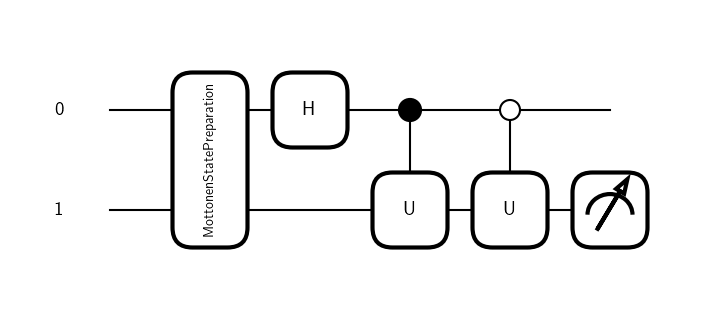

In [17]:
fig, _ = qml.draw_mpl(QET)([h, k])
fig.show()

For those curious about the details, we can get a better idea of the circuit depth and the rotation angles used in state preperation.

In [18]:
print(qml.draw(QET, expansion_strategy="device", max_length=80)([h, k]))

0: ──RY(2.03)─╭●────────────╭●──RZ(1.57)─╭●────────────╭●──H─╭●──────X─╭●──────X─┤
1: ──RY(1.57)─╰X──RY(-1.57)─╰X──RZ(1.57)─╰X──RZ(-1.57)─╰X────╰U(M0)────╰U(M1)────┤

      
   <Z>


We are not focused on optimizing gate depth here, seeing as this is being run on a simulator. An optimal version (c.f. [[2]](#ref2)) can prepare the ground state using CRY gates.

We can now run the circuit to recover $E_B$, the energy extracted by $B$.

In [19]:
E_B_circuit = QET([h, k])
print(f"Energy measured by Bob for (h, k) = ({h}, {k}): {E_B_circuit}")

Energy measured by Bob for (h, k) = (1, 2): -0.6305926250944653


Is there room for improvement? If it is possible to extract more negative energy out of the system, we may be able to get there by tuning $h, k$ that that parametrize our unitary operation.

Let's try a variational approach to finding the optimal parameters. Our goal is to use a simple classical optimizer, where the cost function is simply the output of `QET()`. This is the expectation value of the extracted energy at $B$, which should guide the variational loop into finding the optimal $h, k$.

In [20]:
def optimize_params():
    max_iterations = 300
    step_size = 0.2

    opt = qml.AdamOptimizer(stepsize=step_size)

    init_params = np.array([h, k], requires_grad=True)
    params = init_params
    gd_param_history = [params]

    for n in range(max_iterations):
        # Take step
        params = opt.step(QET, params)
        gd_param_history.append(params)

        energy = QET(params)

        if n % 20 == 0:
            print("Iteration = {:},  \tEnergy = {:.8f}".format(n, energy))

    return params

[h_opt, k_opt] = optimize_params()

print("Variationally optimized Hamiltonian parameters:")
print("\t(h, k) = ({:.8f}, {:.8f})".format(h_opt, k_opt))
print("Variational ground state energy is: {:.8f} ".format(QET([h_opt, k_opt])))


Iteration = 0,  	Energy = -0.63059263
Iteration = 20,  	Energy = -0.99844268
Iteration = 40,  	Energy = -0.93809604
Iteration = 60,  	Energy = -0.96674046
Iteration = 80,  	Energy = -0.96416579
Iteration = 100,  	Energy = -0.96164967
Iteration = 120,  	Energy = -0.96187786
Iteration = 140,  	Energy = -0.96213617
Iteration = 160,  	Energy = -0.96221316
Iteration = 180,  	Energy = -0.96223456
Iteration = 200,  	Energy = -0.96224445
Iteration = 220,  	Energy = -0.96225006
Iteration = 240,  	Energy = -0.96225124
Iteration = 260,  	Energy = -0.96225037
Iteration = 280,  	Energy = -0.96225041
Variationally optimized Hamiltonian parameters:
	(h, k) = (2.74044876, 1.93778940)
Variational ground state energy is: -0.96225048 


Running the variational quantum-classical loop we find some improvement from our arbitrarily chosen values for $h, k$. Can we do even better? Let's try plotting the cost landscape as a function of our parameters to get a better idea of the problem. First, we do a brute force evaluation of the cost function over some domain. Since this is quite expensive, we can adjust `granularity` to change the sampling density.

In [21]:
dom_lo = -5.0
dom_hi = 5.0
granularity = 0.1
h_vals = np.arange(dom_lo, dom_hi, granularity)
k_vals = np.arange(dom_lo, dom_hi, granularity)

energies = np.array([QET([h_val, k_val]) for h_val in h_vals for k_val in k_vals])
energies = energies.reshape(h_vals.shape[0], k_vals.shape[0])

min_idx = np.unravel_index(np.nanargmin(energies, axis=None), energies.shape)
print("Optimal parameters from brute force: (h_opt, k_opt) = {:.2f}, {:.2f}".format(h_vals[min_idx[0]], k_vals[min_idx[1]]))
print(f"Lowest ground state energy from brute force search is: {energies[min_idx]}")

# Smooth out the NaN at (h, k) = (0, 0) before plotting
mask = np.isnan(energies)
energies[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), energies[~mask])

Optimal parameters from brute force: (h_opt, k_opt) = 0.10, -0.00
Lowest ground state energy from brute force search is: -0.9999999999999998


Strangely, our variational optimization failed to find this optimal combination for $h, k$. It makes sense that if Alice inputs $1$ unit of energy, then the maximum negative energy that Bob can extract tends towards $1$ unit as well. Why couldn't we find this simple combination of parameters?

A good guess could be that our optimizer got stuck in a barren plateau! Let's check our intuition by plotting the energy landscape.

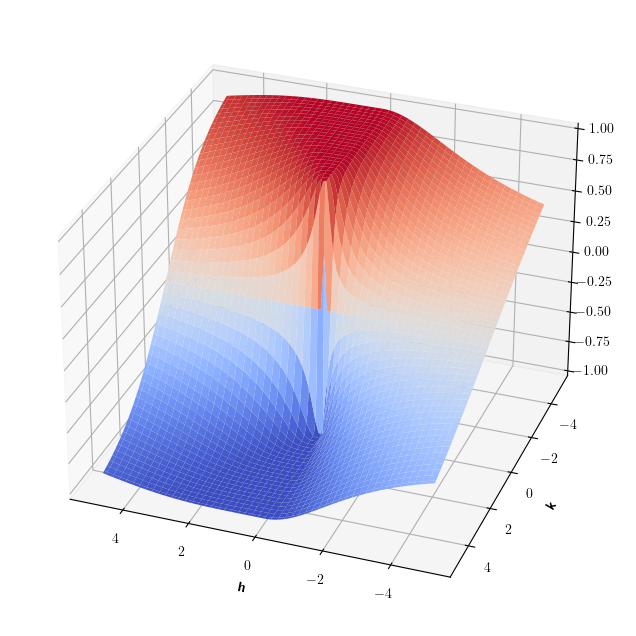

In [22]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))

X, Y = np.meshgrid(h_vals, k_vals)
Z = energies

xlabel = r'\textbf{h}'
ylabel = r'\textbf{k}'

surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm)
plt.setp(ax, xlabel=xlabel, ylabel=ylabel)
ax.view_init(30, 110)

plt.show()

A closer look at the $h=0$ line, suggests this is where our barren plateau is. And our optimized parameters for minimum energy also lie in the plateau, which made optimization difficult using the variational approach. Let's finalize our parameters from the brute force approach before moving on.

In [23]:
h_opt, k_opt = h_vals[min_idx[0]], k_vals[min_idx[1]]

A natural next question could be analysing the effect of noise on the QET protocol. Specifically, what kind of noise are we interested in modelling and what qubits to apply the noise to?

We apply the two kinds of noise - damping and excitation noise - that are supported by `qml.GeneralizedAmplitudeDamping`. We analyze the effect on both qubits, and for convenience apply the noise between steps 1 and 2 of the protocol.

In [24]:
@qml.qnode(dev)
def QET_noisy(params):
    # Step 1
    qml.MottonenStatePreparation(ground_state_vector(params[0], params[1]), wires=range(n_qubits))
    qml.Hadamard(0)

    # Add noise
    qml.GeneralizedAmplitudeDamping(params[2], params[3], wires=params[4])

    # Step 2
    alpha = qml.measure(0)

    # Step 3
    qml.cond(alpha, local_unitary)(1, params[0], params[1], wire=[1])
    qml.cond(~alpha, local_unitary)(-1, params[0], params[1], wire=[1])

    return qml.expval(qml.PauliZ(1))

We are now ready to plot out how noise affects our qubits, and the energy measurement at $B$.

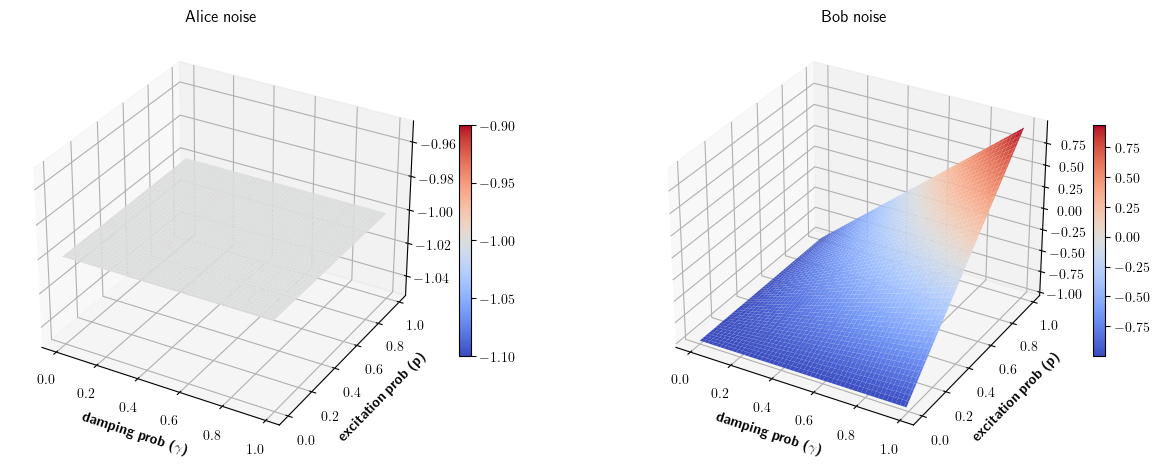

In [25]:
gamma = np.arange(0, 1.0, 0.01)
probs = np.arange(0, 1.0, 0.01)

energies_noisy = []
energies_noisy.append(np.array([QET_noisy([h_opt, k_opt, g, p, 0]) for g in gamma for p in probs]))
energies_noisy.append(np.array([QET_noisy([h_opt, k_opt, g, p, 1]) for g in gamma for p in probs]))

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(15, 15))

X, Y = np.meshgrid(gamma, probs)
Z_0 = energies_noisy[0].reshape(X.shape)
Z_1 = energies_noisy[1].reshape(X.shape)

xlabel = r'\textbf{damping prob ($\gamma$)}'
ylabel = r'\textbf{excitation prob (p)}'

surf_0 = ax[0].plot_surface(X, Y, Z_0, cmap=plt.cm.coolwarm)
plt.colorbar(surf_0, ax=ax[0], shrink=0.2)
ax[0].set_title("Alice noise")

surf_1 = ax[1].plot_surface(X, Y, Z_1, cmap=plt.cm.coolwarm)
plt.colorbar(surf_1, ax=ax[1], shrink=0.2)
ax[1].set_title("Bob noise")

plt.setp(ax, xlabel=xlabel, ylabel=ylabel)
plt.show()

The left plot shows that noise on Alice's qubit does not affect the QET protocol at all. 

The right plot shows that Bob's qubit is unaffected by damping or excitation noise occuring in isolation. Only a combination of both kinds of noise will cause the energy measurement to tend towards a positive value. 

<u>Author</u>: [Niraj Venkat](mailto:venkatn93@gmail.com)

### References

<a id="ref1">[1]</a> M. Hotta, Quantum Energy Teleportation: An Introductory Review [(arxiv)](https://arxiv.org/abs/1101.3954)

<a id="ref2">[2]</a> K. Ikeda, First Realization of QET on Superconducting Quantum Hardware [(arxiv)](https://arxiv.org/abs/2301.02666)
